In [21]:
%matplotlib inline

from py4j.java_gateway import JavaGateway
from py4j.java_gateway import GatewayParameters

import os
import gym
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
import time
from q_learning_bins import plot_running_avg
from PowerDynSimEnvDef_v6 import PowerDynSimEnv, refer_new, referback

In [23]:
java_port = 25006

jar_file = "\lib\RLGCJavaServer0.89.jar"

a = os.path.abspath(os.path.dirname(__file__))

folder_dir = a[:-7]

jar_path = folder_dir + jar_file

case_files_array = []

case_files_array.append(folder_dir + '/testData/IEEE39/IEEE39bus_multiloads_xfmr4_smallX_v30.raw')

case_files_array.append(folder_dir + '/testData/IEEE39/IEEE39bus_3AC.dyr')

dyn_config_file = folder_dir + '/testData/IEEE39/json/IEEE39_dyn_config.json'

rl_config_file = repo_path + '/testData/IEEE39/json/IEEE39_RL_loadShedding_3motor_2levels.json'

import os.path
import sys
# This is to fix the issue of "ModuleNotFoundError" below
sys.path.append(os.path.join(os.path.dirname(__file__), '..'))  


env = PowerDynSimEnv(case_files_array,dyn_config_file,rl_config_file,jar_path,java_port)


4 19 3 2


In [5]:
print(refer_new(5, cnts))
print(referback([1,0,1], cnts))

[1, 0, 1]
5


In [3]:
datafolder = "./storedData008"


def episode_rewards(step_rewards, step_status):
    result = list()
    start = 0
    for i, done in enumerate(step_status):
        if done:
            result.append(sum(step_rewards[start:i+1]))
            start = i+1
    result.append(sum(step_rewards[start:]))
    return np.array(result)

def episode_data(step_data, step_status):
    result = list()
    start = 0
    for i, done in enumerate(step_status):
        if done:
            result.append(sum(step_data[start:i+1]))
            start = i+1
    result.append(sum(step_data[start:]))
    return np.array(result)

In [36]:
dataname = "_lr_5e-05_multistep_randftd_3motor2action_prenull_60w.npy"
step_rewards = np.load(os.path.join(datafolder, "step_rewards" + dataname))
step_actions = np.load(os.path.join(datafolder, "step_actions" + dataname))
step_observations = np.load(os.path.join(datafolder, "step_observations" + dataname))
step_status = np.load(os.path.join(datafolder, "step_status" + dataname))
step_starttime = np.load(os.path.join(datafolder, "step_starttime" + dataname))
step_durationtime = np.load(os.path.join(datafolder, "step_durationtime" + dataname))

In [37]:
rewards = episode_rewards(step_rewards, step_status)
print("total episodes: %d" % (sum(step_status)))

total episodes: 5863


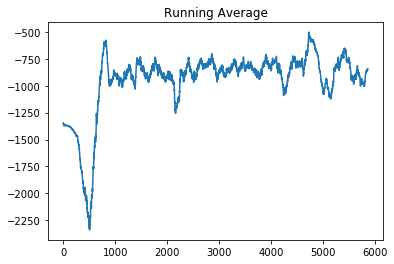

In [38]:
plot_running_avg(rewards)

In [40]:
def getsingle(step_status, step_actions, step_observations, epindex):
    endIndex = np.where(step_status == True)[0]
    single_actions = step_actions[endIndex[epindex]:endIndex[epindex + 1]]
    single_observations = step_observations[endIndex[epindex]:endIndex[epindex + 1]]
    return single_actions, single_observations

In [41]:
epindex = 2500
single2500actions, single2500observations = getsingle(step_status, step_actions, step_observations, epindex)

In [42]:
single2500actions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
from baselines import deepq
import baselines.common.tf_util as U
def test():
    tf.reset_default_graph()
    act = deepq.load("./previous_model/IEEE39_multistep_randbus_3motor2action_prenull_008_lr_5e-05_60w.pkl")
    with tf.variable_scope("deepq", reuse=True):
        eps = tf.get_variable("eps")
    U.set_value(eps, 0)
    print("Check epsilon is: %f" % U.eval(eps))
    
    # candidates = [1, 3, 14, 26]
    # candidates_not_stall = [4,20,24]
    obs, done = env._validate(1,3,0.05,0.05), False
    episode_rew = 0
    actions = list()
    observations = list()
    #noise = 0.01 * np.random.randn(4,8,301)
    i = 0
    while not done:

        action = act(obs[None])[0]


        observations.append(obs)
        actions.append(action)
        obs, rew, done, _ = env.step(action)
        #obs = obs * (1 + noise[:,:,i].flatten())
        #i += 1
        
        episode_rew += rew
    print("Episode reward", episode_rew)

    return np.array(actions), np.array(observations)

In [20]:
def manual_test():

    
    obs, done = env._validate(1,3,0.05,0.08), False
    episode_rew = 0
    actions = list()
    observations = list()
    cnt = 0
    while not done:
  
        #action = act(obs[None])[0]
        #action_lst = [3,3,0,0]
        #action = refer_back(action_lst, cnts)
        
        action = 0
        
        if 1<= cnt <= 4:
            action_lst = [0,1,0]
            action = referback(action_lst, cnts)            
        
        if 6 <=cnt <= 7: #or cnt == 12: # or cnt == 13:
            action_lst = [0,0,1]
            action = referback(action_lst, cnts)        
        #if cnt == 4: #or cnt == 15:
        #    action_lst = [0,1,1]
        #    action = referback(action_lst, cnts)
        #if cnt >= 16:# or cnt == 16:
        #    action_lst = [2,2,2]
        #    action = referback(action_lst, cnts)
        
        #print(action)
        observations.append(obs)
        actions.append(action)
        obs, rew, done, _ = env.step(action)
        episode_rew += rew
        cnt += 1
    print("Episode reward", episode_rew)

    return np.array(actions), np.array(observations)

In [28]:
test_actions, test_observations = test()
#test_actions, test_observations = manual_test()

INFO:tensorflow:Restoring parameters from /tmp/tmpu6sx81pw/model
Check epsilon is: 0.000000
Episode reward -1829.3876867011588


In [32]:
noaction_ob = test_observations

In [9]:
onepreaction_ob = test_observations

In [12]:
validonepreaction_ob = test_observations

In [15]:
purevalidaction_ob = test_observations

In [13]:
def check_actions(actions):
    result = list()
    for i, a in enumerate(actions):
        action_lst = refer_new(a, cnts)
        if np.any(action_lst):
            print("%dth time step take action: " % (i + 1) + str(action_lst))
            

In [29]:
check_actions(test_actions)

4th time step take action: [0, 1, 0]
5th time step take action: [0, 1, 0]


In [34]:
tt = test_observations
xx = np.arange(len(tt))

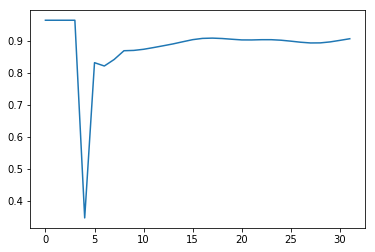

In [35]:
idx = 13
for j in range(idx,idx+ 1):
    plt.plot(test_observations[:,j])
    plt.show()

In [51]:
test_observations[0]

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.00893297,  0.98138364,
        0.97314569,  0.97480137,  0.98712669,  0.96529677,  0.97123479,
        1.0055619 ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.00893297,  0.98138364,  0.97314569,
        0.97480137,  0.98712669,  0.96529677,  0.97123479,  1.0055619 ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.00893297,  0.98138364,  0.97314569,  0.97480137,
        0.98712669,  0.96529677,  0.97123479,  1.0055619 ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.00893297,  0.98138364,  0.97314569,  0.97480137,  0.98

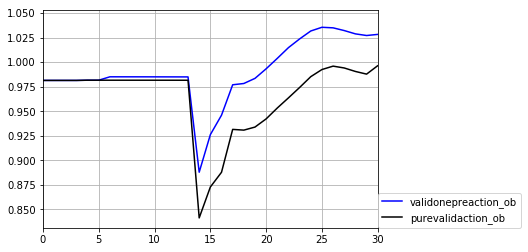

In [26]:
idx = 9
for j in range(idx,idx+ 1):
    #plt.plot(noaction_ob[:,j], color='r',label='noaction_ob')
    #plt.plot(onepreaction_ob[:,j], color='g', label='onepreaction_ob')
    plt.plot(validonepreaction_ob[:,j], color='b', label='validonepreaction_ob')
    plt.plot(purevalidaction_ob[:,j], color='k', label='purevalidaction_ob')
    plt.legend(loc=[1,0])
    #plt.axis([0,10,0.950,1.0])
    plt.xlim([0,30])
    plt.grid(True)
    plt.show()

In [63]:
test_observations[1:20,16]

array([ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  0.7,  0.4,  0.4,  0.4,  0.4])